In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=2)

# 1. Дельта-метод для оценки дисперсии функций от случайных величин

Пусть $X$ распределено нормально и $\sqrt{n}(\bar{X}_n - \mu) \rightarrow N(0, \sigma^2)$, тогда:

$$\sqrt{n}(g(\bar{X}_n) - g(n)\mu) \rightarrow \mathcal{N}\left(0, \sigma^2 g'(\mu)^2\right)$$


Efron (1982) исследовал результаты здачи двух экзаменов LSAT(law school admission test) и GPA (grade point average). Для 15 юридических школ он получил средние значения.

1. Посчитайте корреляцию LSAT и GPA
2. Если *(Х,Y)* двумерное нормальное распределение с коэффициетом корелляции *p* и где *r* - коэффициент корреляции сэмпла, тогда Дельта Метод может быть использован, для того, чтобы показать:

    $$ \sqrt{n}(r-p) \rightarrow N\left(0, (1-p^2 )^2\right)$$

Докажем это. Первым делом вспомним как расчитываются оценки дисперсии и корреляции по сэмплу: 

$$s_{xx} = \frac{1}{N - 1} \sum\limits_{i=1}^{N} (x_i - \bar{x})^2$$

$$s_{xy} = \frac{1}{N - 1} \sum\limits_{i=1}^{N} (x_i - \bar{x}) (y_i - \bar{y})$$

Теперь для дельта-метода нам нужна дисперсии наших оценок:

$$\mathrm{Var} \left( \sqrt{n - 1} 
\begin{bmatrix}
s_{xx} \\
s_{yy} \\
s_{xy}
\end{bmatrix}
\right) = 
\begin{bmatrix}
2 \sigma_{xx}^2 &  & \\
2 \sigma_{xy}^2 & 2 \sigma_{yy}^2 & \\
2 \sigma_{xy} \sigma_{xx} & 2 \sigma_{xy} \sigma_{yy} & \sigma_{xy}^2 + \sigma_{xx} \sigma_{yy}
\end{bmatrix}$$

Вспомним как выглядит оценка коэффициента Пирсона:

$$r = \frac{ s_{xy} }{ \sqrt{ s_{xx} s_{yy}} }$$

Посчитаем производные от коэффициента Пирсона:

$$\frac{\partial r}{\partial \sigma_{xy}} = \frac{1}{\sqrt{ \sigma_{xx} \sigma_{yy} }}$$

$$\frac{\partial r}{\partial \sigma_{xx}} = \frac{\sigma_{xx}}{\sqrt{ \sigma_{xx}^3 \sigma_{yy} }}$$

И теперь финальная формула:

$$(n - 1) \mathrm{Var}(r) \approx \sigma_{11}^2 \left( \frac{\partial r}{\partial \sigma_{xx}} \right) ^2 + \sigma_{22}^2 \left( \frac{\partial r}{\partial \sigma_{yy}} \right) ^2 + \sigma_{33}^2 \left( \frac{\partial r}{\partial \sigma_{xy}} \right) ^2  + \\ \sigma_{12}^2 \frac{\partial r}{\partial \sigma_{xx}}\frac{\partial r}{\partial \sigma_{yy}} + \sigma_{13}^2 \frac{\partial r}{\partial \sigma_{xx}}\frac{\partial r}{\partial \sigma_{xy}} + \sigma_{23}^2 \frac{\partial r}{\partial \sigma_{xy}}\frac{\partial r}{\partial \sigma_{yy}}  =$$
    
$$ = ... = (1 - \rho^2)^2 $$

In [2]:
lsat = [
    576, 580, 653, 635, 555, 
    575, 558, 661, 545, 578, 
    651, 572, 666, 605, 594
]

gpa = [
    3.39, 3.07, 3.12, 3.30, 3.00, 
    2.74, 2.81, 3.43, 2.76, 3.03, 
    3.36, 2.88, 3.44, 3.13, 2.96
]

#### 1. Посчитайте корреляцию LSAT и GPA

In [3]:
from scipy.stats import pearsonr
pearsonr(lsat, gpa)

(0.7763744912894069, 0.0006651020111028177)

In [4]:
corr, _ = pearsonr(lsat, gpa)
corr

0.7763744912894069

In [5]:
var_corr = np.sqrt((1 - corr**2)**2 / (len(lsat) - 1))
print(var_corr)

0.10616756378584874


# 2. Применение профилирования правдоподобия для оценки доверительных интервалов

## 2.1 Оценка погрешности параметров распределения

Вспомним прошлую задачку с оценкой приспособленности разных представителей одного генотипа:

$$\hat{\alpha} = 0.23,~~~ \hat{\beta} = 5.35$$


Просэмплируем обучающую выборку:

In [6]:
from scipy.stats import gamma
alpha_true = 0.23
beta_true = 5.35
X = gamma.rvs(scale=1 / beta_true, a=alpha_true, size=100)

#### Сделаем фитирование по всей выборке

In [7]:
fit_alpha, _, fit_beta = gamma.fit(X, floc=0)
fit_beta = 1 / fit_beta

log_likelihood_max = gamma.logpdf(X, loc=0, a=fit_alpha, scale=1 / fit_beta).sum()
print(fit_alpha, 1 / fit_beta, log_likelihood_max)

0.2492293073276729 0.12074837782922399 375.7359151956887


### Сделаем профилирование правдоподобия по $\alpha$


Теперь более внимательно посмотрим на идею профилирования правдоподобия

0. Находим максимум правдоподобия: $ \mathcal{L}_{max} = \max\limits_{\alpha, \beta} \mathcal{L}(\alpha, \beta)$

1. Берём некоторый интервал $\alpha \in [\alpha_1, \alpha_2]$. 

2. Для каждого $\alpha$ в этом интервале ищем максимум правдоподобия по параметру $\beta$: 

$$\mathcal{L}_\alpha = \max\limits_{\beta} \mathcal{L}(\alpha, \beta) $$

3. Строим график $\alpha, \mathcal{L}_\alpha$ и делаем отсечение $\mathcal{L}_\alpha -  \mathcal{L}_{max} >  -\mathrm{cut\_level}_{0.95}$, где 


$$\mathrm{cut\_level}_{0.95} = \chi_{0.95}^{2}(1) / 2$$

In [8]:
from scipy.stats import chi
q = 0.95
cut_level = chi.ppf(q=q, df=1) / 2

In [9]:
fit_alphas = []
fit_betas = []
log_likelihoods = []
alphas = np.linspace(0.1, 0.5, 100)
for alpha in alphas:
    fit_alpha, _, fit_beta = gamma.fit(X, floc=0, fa=alpha)
    fit_betas.append(1 / fit_beta)
    fit_alphas.append(fit_alpha)
    log_likelihoods.append(gamma.logpdf(X, loc=0, a=alpha, scale=fit_beta).sum())

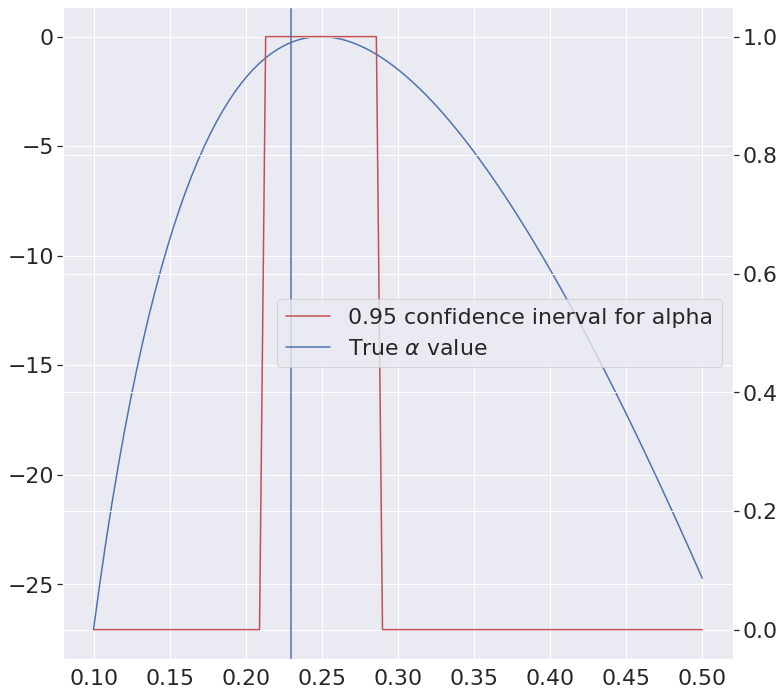

In [10]:
plt.figure(figsize=(12, 12))
plt.plot(alphas, 
         (np.array((log_likelihoods)) - log_likelihood_max), 
         label='Likelihood value')
plt.twinx()
plt.plot(alphas, 
         (np.array((log_likelihoods)) - log_likelihood_max > -cut_level), 
         c='r', label='{} confidence inerval for alpha'.format(q))
plt.axvline(alpha_true, label=r'True $\alpha$ value')
plt.legend()
plt.show()

### Профилируем likelihood по $\beta$

Делаем всё тоже самое

In [11]:
fit_alphas = []
fit_betas = []
log_likelihoods = []
betas = np.linspace(0.001, 10, 100)
for beta in betas:
    # <YOUR CODE>
    fit_alpha, _, fit_beta = gamma.fit(X, floc=0, fscale=1 / beta) # scale=1 / beta, a=alpha
    fit_betas.append(1 / fit_beta)
    fit_alphas.append(fit_alpha)
    log_likelihoods.append(gamma.logpdf(X, loc=0, a=fit_alpha, scale=fit_beta).sum())

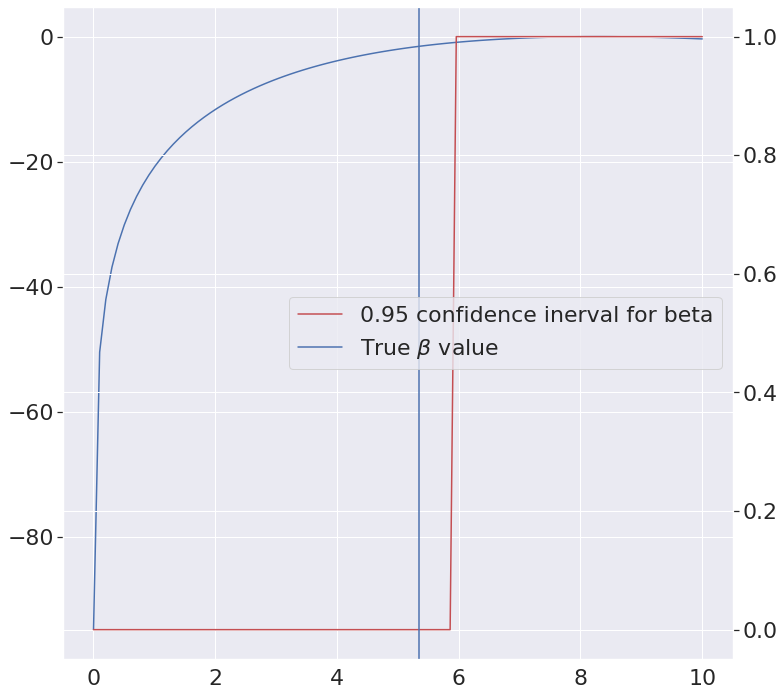

In [12]:
plt.figure(figsize=(12, 12))
plt.plot(betas, 
         (np.array((log_likelihoods)) - log_likelihood_max), 
         label='Likelihood value')
plt.twinx()
plt.plot(betas, 
         (np.array((log_likelihoods)) - log_likelihood_max > -cut_level), 
         c='r', label='{} confidence inerval for beta'.format(q))
plt.axvline(beta_true, label=r'True $\beta$ value')
plt.legend()
plt.show()

### 2.2 2D профилирование likelihood

In [13]:
alphas, betas = np.meshgrid(alphas, betas)

In [14]:
alphas.shape

(100, 100)

In [15]:
log_likelihoods = []
for alpha, beta in zip(alphas.ravel(), betas.ravel()):
    log_likelihoods.append(gamma.logpdf(X, loc=0, a=alpha, scale=1 / beta).sum() - log_likelihood_max)

In [16]:
len(log_likelihoods)

10000

In [17]:
log_likelihoods = np.array(log_likelihoods).reshape(alphas.shape)

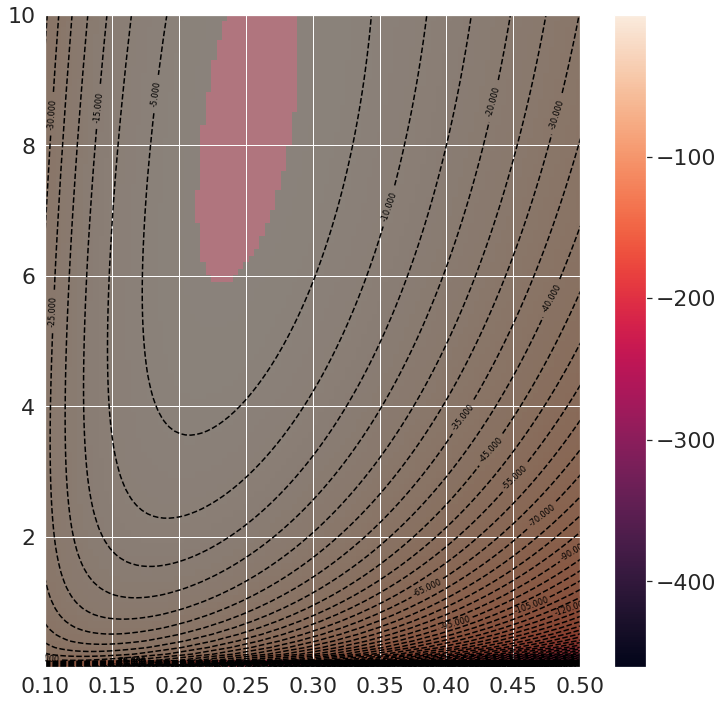

In [18]:
plt.figure(figsize=(12, 12))
contours = plt.contour(alphas, 
                       betas, 
                       log_likelihoods, 
                       100, 
                       colors='black')
plt.clabel(contours, inline=True, fontsize=8)

plt.imshow(log_likelihoods, extent=[0.1, 0.5, 0.001, 10], 
           aspect='auto', origin='lower', alpha=1.)
plt.colorbar();

plt.imshow(100 * (log_likelihoods < -cut_level), 
           extent=[0.1, 0.5, 0.001, 10], 
           aspect='auto', origin='lower',
           cmap='RdGy', alpha=0.5)

# 3. Применение информации Фишера для оценки доверительных интервалов

Информацию Фишера можно использовать для расчёта ошибок в оценке параметров и корреляций ошибок(что с профилированием likelihood гораздо менее тривиально сделать). 

Это делается из [неравенства Крамера-Рао](https://ru.wikipedia.org/wiki/%D0%9D%D0%B5%D1%80%D0%B0%D0%B2%D0%B5%D0%BD%D1%81%D1%82%D0%B2%D0%BE_%D0%9A%D1%80%D0%B0%D0%BC%D0%B5%D1%80%D0%B0_%E2%80%94_%D0%A0%D0%B0%D0%BE), которое утверждает, что снизу дисперсия параметра ограничена диагональным членом матрицы обратной к матрице Фишера.

Посмотрим на оценку дисперсии параметров некоторого периодичного сигнала.

## 3.1 Фитирование кривой

### Постановка задачи

#### Условие

Пусть у нас есть некоторый сигнал:

$$a(t) = A \sin(2 \pi f t + \phi)$$


При передаче сигнала он зашумляется. Предположим, что нам известна форма и параметры шума: $\mathcal{N}(0, \sigma^2)$. Тогда мы будем наблюдать следующий сигнал в момент времени $t_i$:

$$\hat{a}_i \sim A \sin(2 \pi f t_i + \phi) + \mathcal{N}(0, \sigma^2) = \mathcal{N}\left(A \sin(2 \pi f t_i + \phi), \sigma^2 \right)$$


#### Задача

По набору измерений: $\{t_i\}_{i=1}^{N}$ и $\{\hat{a}_i\}_{i=1}^{N}$(на самом деле измерения нам даже не понадобятся) мы хотим:
  * оценить ошибки восстановления параметров;
  * оценить "важность" какждого измерения для оценки каждого из параметров.

In [19]:
from scipy.misc import derivative
from scipy.optimize import curve_fit
import inspect
import matplotlib.pyplot as plt
import numpy as np

В качестве сигнала мы возьмём синус со следующими параметрами: амплитуда, частота и фаза.

Text(0.5, 0, 'time (s)')

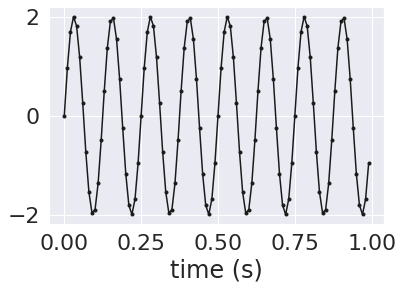

In [20]:
def signal(t, a, f, ph):
    return a * np.sin(2 * np.pi * f * t + ph)

parameters = {
    'a': 2,
    'f': 8,
    'ph': 0
}
noise = 0.1

T = np.arange(0, 1, 0.01)
plt.plot(T, signal(T, **parameters), '.-k')
plt.xlabel('time (s)')

### Вывод формул

Введём формальную терминологию.

Вектор параметров:

$$\theta = [A, f, \phi]$$

Вероятностная модель:

$$\hat{a}_i(\theta) \sim \mathcal{N}\left(A \sin(2 \pi f t_i + \phi), \sigma^2 \right)$$

$$\log p(\hat{a}_i) = - \frac{1}{2\sigma^2} \left( \hat{a}_i - A \sin(2 \pi f t_i + \phi)  \right)^2 - \log 2 \pi - \frac{1}{2} \log \sigma$$

Матрица Фишера для одного измерения:

$$\mathcal{I}(\theta) = \mathbb{E} \left( \left(\frac{\partial \log p(\hat{a}_i)}{\partial \theta}\right) \left(\frac{\partial \log p(\hat{a}_i)}{\partial \theta}\right)^T \right) = \mathbb{E} \left( \frac{\partial^2 \log p(\hat{a}_i)}{\partial \theta^2} \right)$$


Найдём же эту вторую производную:

$$\frac{\partial \log p(\hat{a}_i)}{\partial \theta_i} = -\frac{1}{\sigma^2} a'_{\theta_i} \left( a(t_i) - \hat{a}_i \right)$$


$$\frac{\partial^2 \log p(\hat{a}_i)}{\partial \theta_i \partial \theta_j} = -\frac{1}{\sigma^2} a''_{\theta_i,~\theta_j} \left( a(t_i) - \hat{a}_i \right) - \frac{1}{\sigma^2} a'_{\theta_i} a'_{\theta_j}$$ 

$$\mathbb{E} \left( \frac{\partial^2 \log p(\hat{a}_i)}{\partial \theta_i \partial \theta_j} \right) = - \frac{1}{\sigma^2} a'_{\theta_i} a'_{\theta_j}$$


Тогда матрица Фишера выражается следующим образом:

$$\mathcal{I} =  -\sum_i \mathbb{E} \left( \frac{\partial^2 \log p(\hat{a}_i)}{\partial \theta^2} \right) = \frac{1}{\sigma^2} \sum_i \left( \frac{\partial a(t_i)}{\partial \theta} \right) \left( \frac{\partial a(t_i)}{\partial \theta} \right)^T$$


Переопределим: $D_{mi} := \frac{\partial a(t_i)}{\partial \theta_m}$, тогда:

$$\mathcal{I}_{mn} = \frac{1}{\sigma^2} \sum_i \frac{\partial a(t_i)}{\partial \theta_m} \frac{\partial a(t_i)}{\partial \theta_n} = \frac{1}{\sigma^2} \sum_k D_{mi} D_{ni}$$

In [21]:
{**parameters, **{'a': 5}}

{'a': 5, 'f': 8, 'ph': 0}

In [22]:
D = np.zeros((len(parameters), len(T)))

# для каждого параметра
for i, argname in enumerate(parameters.keys()):
    # для каждого измерения
    for k, t in enumerate(T):
        # определим функцию по которой будем считать производную
        func = lambda x: signal(t, **{**parameters, **{argname: x}})
        
        # посчитаем производную
        D[i,k] = derivative(func, parameters[argname], dx=0.0001)

Посмотрим на зависимость $D$ для разных переменных. 

Заметим ещё раз, что по количество строк в матрице $D$ совпадает с длиной вектора $\theta$, а количество столбцов с количеством измерений.

In [23]:
D.shape

(3, 100)

Text(0.5, 0, 'time (s)')

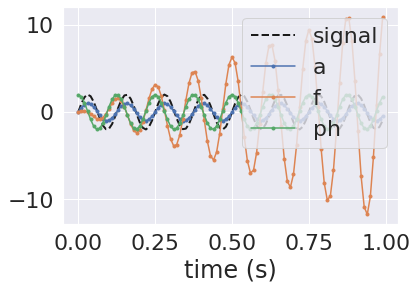

In [24]:
plt.plot(T, signal(T, **parameters), '--k', lw=2, label='signal')

for Di, argname in zip(D, parameters.keys()):
    plt.plot(T, Di, '.-', label=argname)
    
plt.legend(loc='best')
plt.xlabel('time (s)')

Матрица $D_{ik}$ показывает как сильно $k$-ое измерение влияет на $i$-ый параметр. К примеру, видно, что на параметр амплитуды сильнее всего влияют значения в пиках синуса. 

Кроме того, последние точки оказываются более чувствительными к частоте. 

А теперь посчитаем матрицу Фишера по матрице $D$:
$$\mathcal{I}_{m,n}= \frac{1}{\sigma^2} \sum_k D_{mk} D_{nk}$$

Посчитаем это с помощью функции из numpy: [```einsum```](http://docs.scipy.org/doc/numpy/reference/generated/numpy.einsum.html)

In [25]:
I = np.einsum('ij,kj', D, D) / noise**2
print(I)

[[ 5.00000000e+03 -5.71453545e+02 -1.55465640e-09]
 [-5.71453545e+02  2.55477009e+05  6.15752139e+04]
 [-1.55465640e-09  6.15752139e+04  1.99999999e+04]]


В ячейчке выше мы посмотрим на дисперсии оценок на параметры сигнала с помощью Крамера-Рао.

In [26]:
I_inv = np.linalg.inv(I)

for argname, variance in zip(parameters.keys(), I_inv.diagonal()):
    print('{}: {:.2g}'.format(argname, np.sqrt(variance)))

a: 0.014
f: 0.0039
ph: 0.014


А здесь мы воспользуемся функцией `curve_fit`, которая делает автоматический фит по конечной выборке и выдаёт оптимальные параметры и ошибки.

Как видно, они достаточно похожи.

Стоит отметить, что некорректно сравнивать ошибки посчитанные с помощью Крамера-Рао и `curve_fit`, так как они имеют достаточно разную природу. 

a: 0.016
f: 0.0044
ph: 0.016


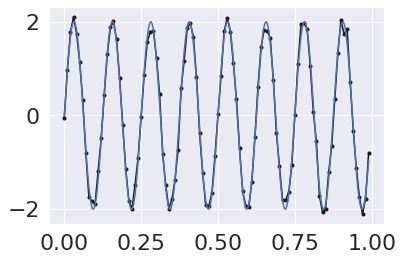

In [27]:
S = signal(T, **parameters) + np.random.randn(T.size) * noise
plt.plot(T, S, '.-k')

popt, pcov = curve_fit(signal, T, S, p0=list(parameters.values()))

for argname, variance in zip(parameters.keys(), pcov.diagonal()):
    print('{}: {:.2g}'.format(argname, np.sqrt(variance)))

Tl = np.linspace(T[0], T[-1], 10000)
plt.plot(Tl, signal(Tl, *popt))

In [28]:
def cramer_rao(model, p0, X, noise, show_plot=False):
    D = np.zeros((len(p0), X.size))
    for i, argname in enumerate(parameters.keys()):
        for k, t in enumerate(X):
            func = lambda x: signal(t, **{**parameters, **{argname: x}})
            D[i,k] = derivative(func, parameters[argname], dx=0.0001)
        
    if show_plot:
        plt.plot(X, model(X, **parameters), '--k', lw=2, label='signal')
        for Di, argname in zip(D, parameters.keys()):
            plt.plot(T, Di, '.-', label=argname)

        plt.legend(loc='best')
        plt.title('Зависимость параметра от ошибки измерения в конкретной точки')
    
    I = np.einsum('mk,nk', D, D) / noise**2
    I_inv = np.linalg.inv(I)
    
    return I_inv

На графике ниже мы показываем как ошибки в определённых точках влияют на оценку параметров $\theta$.

Text(0.5, 0, 'time (s)')

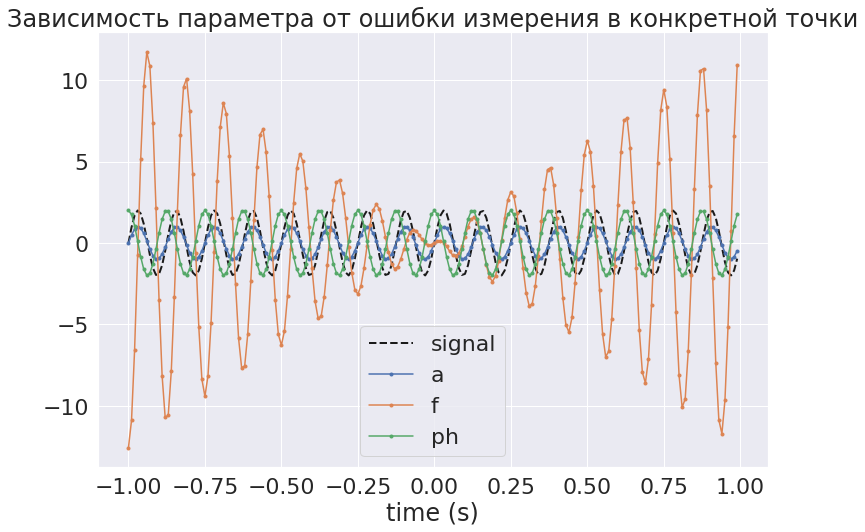

In [29]:
plt.figure(figsize=(12, 8))

T = np.arange(-1., 1, 0.01)
cramer_rao(signal, parameters, T, noise, show_plot=True);
plt.xlabel('time (s)')

## 3.2 Вернёмся к задаче с "относительной приспособленностью"

In [30]:
from scipy.special import polygamma

#### Посчитаем матрицу Фишера

In [31]:
def calc_I_matrics(alpha, beta):
    # <YOUR CODE>
    I_matrics = [
        [-polygamma(1, alpha), 1 / beta],
        [1 / beta, -alpha / beta**2]
    ]
    return -np.array(I_matrics)

In [32]:
I_matrics = calc_I_matrics(alpha=alpha_true, beta=beta_true)

##### Воспользуемся тождеством Рао-Крамера

In [33]:
variance_matrix = np.linalg.inv(I_matrics) / len(X)

In [34]:
variance_matrix

array([[6.33704832e-04, 1.47405254e-02],
       [1.47405254e-02, 1.58733396e+00]])

In [35]:
variance_matrix[0, 1] / np.sqrt(variance_matrix[0, 0] * variance_matrix[1, 1])

0.46476701840878426

In [36]:
np.sqrt(variance_matrix[0, 1] / np.sqrt(variance_matrix[0, 0] * variance_matrix[1, 1]))

0.6817382330548759

In [37]:
variance_matrix[0, 0]

0.0006337048323410921

In [38]:
variance_matrix[1, 1]

1.5873339615062927